# Lab 3: Population genetics and GWAS


## Part 1 (40 pts)

Skills covered: genotype data, principal components analysis, ancestry analysis

Your friend is interested in learning more about her family history, and so sends a saliva sample off to 23andMe for genotyping. You receive a set of SNP genotypes back, and would like to use those to predict the ancestry of your friend.

We can get some insights into the ancestry of an unknown genome sample by comparing it to SNP genotypes of a *reference panel* of samples for which we know their ancestry. We can think of this as a clustering problem: if I cluster a genome with genomes from across the globe, what cluster does it fall in?

Clustering by SNP genotypes turns into a high-dimensional problem, because we can be dealing with millions of SNPs and thousands or more individuals. Principal components analysis (PCA) is a widely used method for helping make sense out of big multi-dimensional datasets like this one. We'll use PCA to see where our example genome falls relative to a panel of several thousand reference control samples, originally sequenced by the [1000 Genomes Project](http://www.internationalgenome.org/).

In Part 1, we'll first gain some intuition about principal component analysis (PCA) and then spend some time getting more familiar with population genetics datasets (mainly VCF files), analysis tools (`bcftools`), and terminology. Then we'll perform ancestry analysis using PCA. In Part 2, we'll use a subset of samples from the 1000 Genomes Project to peform a genome-wide association study for LDL cholesterol.

**<font color="red">Note</a>**: you will not be responsible for knowing any of the math behind PCA, but you should instead try to get an intuition for what PCA is doing. We will also post some extra slides with more details for anyone that is interested.

**<font color="red">Note</a>**: In parts of this lab we'll be using the [Python pandas](https://pandas.pydata.org/) library, which is very useful for analyzing anything where you have tables of data. While most of the pandas code is provided for you, it is a good idea to become comfortable using this library.

## 1. Intro to PCA

<font color="red">This section is completely for data exploration. There are no points associated with this section.</font>

PCA is a commonly used method to reduce the "dimensionality" of a dataset. This comes up in a wide range of bioinformatics applications:

* Preprocessing step to filter out outlier samples
* Data exploration
* Determining ancestry of an individual (the topic of part 1 of the lab!)
* Clustering tumor samples based on expression profiles

This first section gives some intuition for how PCA works.

Biology is full of "high-dimensional" data. In our population genetics applications this week, our "dimensions" are the genetic variants (SNPs). For most population genetics applications, we may have several million SNP genotypes per sample. In gene expression applications (next week), our "dimensions" might be genes. In both cases, the goal of PCA is to find a reduced representation by finding linear combinations of dimensions (in our example, SNPs) that explain the majority of variation in our data.

Let's start by walking through a simple example: you do a survey of your classmates to record their height and weight. The cell below generates this dataset for you and puts it into a pandas data frame (this is simulated data, but pretend we collected it!)

In [1]:
%pylab inline
# Simulate some random "weight" vs. "height" data.
import numpy as np
import pandas as pd

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

height = X[:,0]+65
weight = X[:,1]+120

data = pd.DataFrame({"height": height, "weight": weight})

# You can use `data.head()` to see the columns of the data frame.
# Recall `data["height"]` and `data["weight"]` will access those two columns:
data.head()

Populating the interactive namespace from numpy and matplotlib


,height,weight
0,64.374698,119.829936
1,65.960695,120.590901
2,64.401457,119.597407
3,62.771941,119.467423
4,64.538570,119.501133


Now let's create a scatter plot of this data:

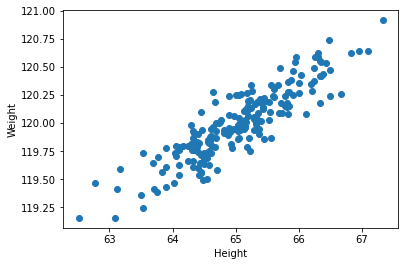

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data["height"], data["weight"]);
ax.set_xlabel("Height")
ax.set_ylabel("Weight");

If you had to draw one single line explaining most of the variation in your sample, where would you draw it? What about a line that explains the second most amount of variation?

You might guess that a diagonal line explains most of the variation, and the second largest axis of variation would be orthogonal to the diagonal line.

These lines, or "axes" are exactly what PCA tries to find: linear combinations of features in our data that explain as much variation as possible. Let's actually perform PCA on our data to check our answer.

In [3]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(data[["height","weight"]])

pc_magnitudes = pca.explained_variance_
pcs = pca.components_
print("PC 1 - magnitude: %s"%pc_magnitudes[0])
print("PC 1: %s"%pcs[0])
print("PC 2 - magnitude: %s"%pc_magnitudes[1])
print("PC 2: %s"%pcs[1])

PC 1 - magnitude: 0.7625315008826105
PC 1: [-0.94446029 -0.32862557]
PC 2 - magnitude: 0.01847789551356239
PC 2: [-0.32862557  0.94446029]


The **principal components** give us the principal *directions* of variation in our data.

The **magnitudes** give us a relative indication of how much variation is explained by each direction (eigenvector).

We can plot vectors for the principal components (PCs) on our original dataset, and scale them by the their relative magnitudes to see their relative contribution of each PC. Do the directions and magnitude match what you predicted? Do both PCs explain about equal amounts of variation in our data, or is one dominant?

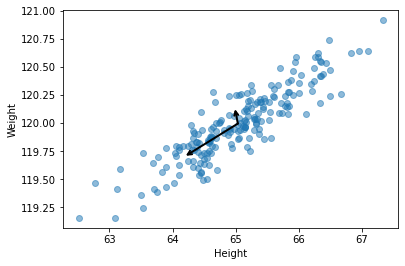

In [4]:
"""
Draw a an arrow from point1 to point2.
Takes an input a matplotlib ax object so
you can add to an existing plot
"""
def DrawArrow(point1, point2, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', point2, point1, arrowprops=arrowprops)

# Make arrows start at the mean of each dimension
mean_vals = [np.mean(data["height"]), np.mean(data["weight"])]
point1 = mean_vals

# Draw one earrow for pc1, and pc2, corresponding to the direction (eigvector) of each PC
# Scale each arrow relatively based on eigenvalues
pc1_point2 = mean_vals+pcs[0]*np.sqrt(pc_magnitudes[0])
pc2_point2 = mean_vals+pcs[1]*np.sqrt(pc_magnitudes[1])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data["height"], data["weight"], alpha=0.5);
DrawArrow(point1, pc1_point2, ax=ax)
DrawArrow(point1, pc2_point2, ax=ax)
ax.set_xlabel("Height")
ax.set_ylabel("Weight");

Now that we have the PCs, we can visualize our data in PC space by "projecting" each point onto the top 2 PCs.  

Below shows how to do this using the `fit_transform` method of `sklearn`.

Note, here we only had 2 dimensions to begin with, so the top two PCs explain all of the variation in our data. So our plot should basically look like a random cloud of data. In future examples with many more dimensions, plotting the highest PCs of our data will help visualize clusters of related samples (see below).

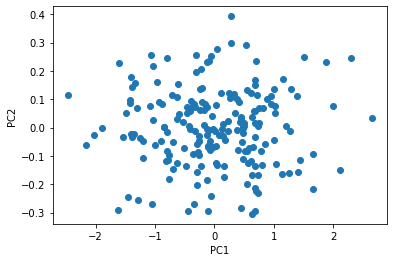

In [5]:
# Project data onto top PCs:

# Using sklearn transform method
data_transformed_sklearn = pca.transform(data[["height","weight"]])

# Compare
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data_transformed_sklearn[:,0], data_transformed_sklearn[:,1])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

## 2. VCFs and command line fun

Now that you have a feel for what PCA is doing, let's apply it to our human genetics dataset. You have performed SNP genotyping on a cohort of individuals consisting of diverse ancestral backgrounds (including African, European, East Asian, and Native American) to use as a reference panel for ancestry analysis. 

First, let's take a look at the data files we have collected in the `lab3` directory:

```shell
ls -ltrh ~/public/lab3/
```

You should see:
* `gtdata_1000Genomes.vcf.gz` (1.7G): A VCF file with SNP genotypes for our cohort
* `gtdata_1000Genomes.vcf.gz.tbi` (308K): The VCF index file
* `gtdata_sample_labels.csv`: gives a population label for each of our samples. See  http://www.internationalgenome.org/category/population/ for a description of the codes.

We'll also be using these files in the next sections:
* `friend_genome.vcf.gz` (8.9M): A VCF file with the friend genome (and it's `.tbi` index). (This is actually Melissa's genome, downloaded directly from 23andMe)
* `pruned_snps_hg19.bed.gz` (5.3M): A gzipped list of SNP locations we'll be using for PCA (more on this below).

Other files will be used in part 2 (ignore for now).

It's always a good idea to first do some basic sanity checks and exploration of our data. We'll first review some UNIX commands to get some summary statistics. Later we'll learn how to use `bcftools` to conveniently manipulate VCF files. If you need a refresher on VCF format, remember to look back at the [VCF spec](https://samtools.github.io/hts-specs/VCFv4.2.pdf) as a guide.

Take a look at the top of the VCF file. Since this zipped, you won't be able to use things like `cat` or `head` directly on the file. But you can use the command `zcat` which is like cat but for zipped files.

**Question 1 (2 pts)**: Looking at the header of the VCF file, what was the reference genome assembly version used to call these variants? 

Set `q1_ref` to the assembly version. You can find this in the header line starting with `##reference`, which points to a file named `<refassemblyname>.fa`.

Set `q1_ref_cmd` to the command you used to look at the file.

By the way, note this reference is slightly different than hg19, which included "chr1", "chr2", etc. This reference uses "1", "2", etc. (without the "chr") but the positions are otherwise mostly equivalent to hg19.

In [6]:
""" Question 1 answers """

# set to the reference assembly. e.g. if the fasta hg19.fa was used, q1_ref would be set to "hg19"
q1_ref = ""

q1_ref_cmd = """
Set this to the command you used to look at the VCF file
"""

# your code here
q1_ref = "hs37d5"
q1_ref_cmd = "zcat ~/public/lab3/gtdata_1000Genomes.vcf.gz | head -n 5"
# raise NotImplementedError

In [7]:
""" Autograder tests - Q1 """

#### Check q1_ans ####
assert("/" not in q1_ref)
assert(q1_ref.startswith("hs"))
assert(q1_ref.endswith("d5"))
assert(len(q1_ref.strip())==6)

# Hidden test checks answer

In [8]:
""" Autograder tests - Q1 """

#### Check q1_ref_cmd ####
assert("gtdata_1000Genomes.vcf.gz" in q1_ref_cmd)

The `tabix` tool provides multiple utilities for making VCF files faster to parse and summarize. Type `tabix` at the command line to see usage. Frequently used commands:

* `tabix -p vcf <myvcf.vcf.gz>` creates an index file `myvcf.vcf.gz.tbi`. This requires your VCF file to be sorted in the first place. Once the index is created, other tools, like `tabix` and `bcftools` can quickly extract important information from VCFs.
* `tabix myvcf.vcf.gz chrom:start-end` will extract only variants (records) from the given genomic region. This can be very useful when you have a huge VCF file and grepping would take forever. This requires the VCF to be indexed.

**Question 2 (3 pts)**: We actually only chose a couple chromosomes to analyze in order to save run time and space (this will be suffficient for our PCA analysis). Set `q2_chroms` to a list of the names of the chromosomes included in this file.

You could answer this with a combination of UNIX commands. There is also a much faster way to do this using `tabix` (see the `tabix` help message).

In [14]:
""" Question 2 answers """

q2_chroms = [] # set to a list of the chromosomes present in gtdata_1000Genomes.vcf.gz

# your code here
q2_chroms = [2, 15]
# raise NotImplementedError

In [15]:
""" Autograder tests - Q2 """

# Basic checks on q2_chroms
assert(len(q2_chroms)==2)

for item in q2_chroms:
    assert("chr" not in str(item))
assert(sum([int(item) for item in q2_chroms])==17)

In [16]:
""" Autograder tests - Q2 """

# More checks on q2_chroms
assert(2 in q2_chroms or "2" in q2_chroms)

# Additional hidden tests

Scroll down to the first variant entry (2:10179) after the header lines, which all start with a `#`. You might find the command:

```shell
zcat ~/public/lab3/gtdata_1000Genomes.vcf.gz | less -S 
```

helpful for scrolling. And if you're impatient you can type "ctrl+v" to page down very quickly.

You'll notice a funny looking string `rs567117114` in the third column (`ID`). This is the "dbSNP" identifier for this variant (although this actually happens to be an indel!). dbSNP is a catalog of genetic variation, and is a convenient place to look up things like allele frequencies of a SNP in different populations. For intsance, you can see more info about the first variant here: https://www.ncbi.nlm.nih.gov/snp/rs567117114. In human genetics research, we often talk about "rsIDs", which refer to dbSNP identifiers.

Use the `tabix` tool to look at data for a specific SNP, rs12913832

```shell
tabix ~/public/lab3/gtdata_1000Genomes.vcf.gz 15:28365617-28365618 | \
  grep rs12913832 | cut -f 1-9
```

Note in this command:
* `tabix <vcf> <region>` pulls out a specific chromosomal region from a VCF file (rather than having to grep through the whole file which would take a long time.
* `grep XXX` searches the resulting lines for a pattern, here the rsid. 
* `cut -f 1-9` shows us the first 9 columns of that line.

**Question 3 (4 pts)**: The SNP [rs12913832](https://www.snpedia.com/index.php/Rs12913832) is strongly associated with blue eye color. According to the our VCF file, what is the alternate allele frequency of this SNP in Europeans? Africans? East Asians? Set the variables q3_EUR, q3_AFR, and q3_EAS to your answers below.

Note, you can look at the VCF header to figure out what each of the INFO fields mean.

In [17]:
""" Question 3 answers """

# Set the variables below to the alternate allele frequency of this SNP in 
# the different population groups based on the INFO fields in gtdata_1000Genomes.vcf.gz
q3_EUR = -1
q3_AFR = -1
q3_EAS = -1

# your code here
q3_EUR = 0.6362
q3_AFR = 0.028
q3_EAS = 0.002
# raise NotImplementedError

In [18]:
""" Autograder tests - Q3 """
# Check frequencies are reasonable
assert(q3_EUR > 0 and q3_EUR < 1)
assert(q3_EUR > q3_AFR and q3_EUR > q3_EAS)

# Hidden tests check actual values

In [19]:
""" Autograder tests - Q3 """
# Check frequencies are reasonable
assert(q3_EAS > 0 and q3_EAS < 1)
assert(q3_EAS < q3_AFR)

# Hidden tests check actual values

In [20]:
""" Autograder tests - Q3 """
# Check frequencies are reasonable
assert(q3_AFR > 0 and q3_AFR < 1)

# Hidden tests check actual values

**Question 4 (6 pts)**: How many total variants are included in our VCF file? How many samples (people) are included? Set `q4_variants` and `q4_samples` to your answers. Set `q4_cmds` to the commands you used to answer these.

The fastest way to do this is to use tools built specifically to take advantage of the VCF index file to perform computations very quickly on VCF files. `bcftools` provides many utilities for manipulating VCF files. See if you can figure out how to get information about the number of variants and the number of samples using the following commands:

* `bcftools index` has an option to print the number of variants in a VCF file. (hint, a "record" means "variant")
* `bcftools query` has an option to list the samples in a VCF file. You can pipe this to another command (for instance, involving `wc`) to count the number of samples.

Type of each these commands at the terminal to see basic usage.

In [21]:
""" Question 4 answers """

q4_variants = -1 # number of variants in the VCF file
q4_samples = -1 # number of samples in the VCF file
q4_cmds = """
""" # paste your commands to answer the above here

# your code here

q4_variants = 9506289
q4_samples = 2504
q4_cmds = """
bcftools index -n  ~/public/lab3/gtdata_1000Genomes.vcf.gz
bcftools query -l ~/public/lab3/gtdata_1000Genomes.vcf.gz | wc -l
"""

# raise NotImplementedError

In [22]:
""" Autograder tests - Q4 """
assert(q4_variants > 1000000)
assert(q4_variants < 10000000)
assert(type(q4_variants) == int)

# Hidden tests check actual values

In [23]:
""" Autograder tests - Q4 """
assert(q4_samples > 2000)
assert(q4_samples < 3000)
assert(type(q4_samples) == int)

# Hidden tests check actual values

In [24]:
""" Autograder tests - Q4 """
assert(q4_cmds.strip() != "")
assert("gtdata_1000Genomes.vcf.gz" in q4_cmds)

## 3. Preprocessing our data for PCA

To perform PCA, we'll first want to "prune" our variants to get variants that are relatively independent and remove rare variants that might be potential outliers in our analysis. To save time we have already provided you a good list of SNPs to use:

```
~/public/lab3/smallpruned_snps_hg19.bed.gz
```

This is a [BED file](https://genome.ucsc.edu/FAQ/FAQformat.html#format1), a common format in genomics analyses. BED files simply store regions, or "chunks" of the genome, with one chunk per line. In our case, the BED file contains a list of positions we will want to extract from our dataset. There are 3 main columns: chromosome, start, and end position. Do `zcat` on the file to take a look. BED files can sometimes have other score or strand information, but we won't use the extra columns here.

**Question 5 (6 pts)**: Use `bcftools view` to extract variants falling in this list of regions from the VCF file `gtdata_1000Genomes.vcf.gz`.

How many variants remain in your pruned VCF file (it should be way fewer than the original file. close to 5,000)?

See the usage for how to use the following options:
* Input a file containing a list of regions (this can be our `smallpruned_snps_hg19.bed.gz` above.
* Output the VCF in gzipped format.
* Output the new VCF file to `~/lab3/gtdata_1000Genomes_pruned.vcf.gz`
* Output only SNPs.

After you have generated the pruned VCF file, use `tabix` to index it (e.g. `tabix -p vcf ~/lab3/gtdata_1000Genomes_pruned.vcf.gz`)

Set `q5_numvars` to the number of variants remaining and `q5_cmds` to the commands you used to extract these variants to a new VCF file, index the new VCF file, and count the number of variants in the new file. (This might take a minute or two).

In [25]:
""" Question 5 answers """
q5_numvars = -1 # number of variants remaining after pruning
q5_cmds = """
""" # set to the commands you used for pruning

# your code here
q5_numvars = 5183
q5_cmds = """
bcftools view -R ~/public/lab3/smallpruned_snps_hg19.bed.gz -o ~/lab3/gtdata_1000Genomes_pruned.vcf.gz -O z -v snps ~/public/lab3/gtdata_1000Genomes.vcf.gz
tabix -p vcf ~/lab3/gtdata_1000Genomes_pruned.vcf.gz
bcftools index -n ~/lab3/gtdata_1000Genomes_pruned.vcf.gz
"""
# raise NotImplementedError

In [26]:
""" Autograder tests - Q5 """
# Checks on q5_numvars
assert(q5_numvars > 5000 and q5_numvars < 6000)

In [27]:
""" Autograder tests - Q5 """
# checks on q5_cmds
assert("bcftools" in q5_cmds)
assert("view") in q5_cmds

In [28]:
""" Autograder tests - Q5 """
# checks on q5_cmds
assert("tabix" or "index" in q5_cmds)

## 4. Running PCA

Now we are ready to run our PCA. To simplify this, we will use a tool called [plink](https://www.cog-genomics.org/plink/1.9/). plink can perform a huge number of tasks, including PCA (lab 3 part 1), GWAS (lab 3 part 2), and wrangling VCF or other genetics file formats in many ways. But almost every plink command includes the following elements:

* An option to specify a path to genotypes. e.g. `--vcf myvcffile.vcf.gz`. Plink also accepts multiple other genotype formats, but we'll ignore those.
* A command to perform. e.g. `--linear` to perform a GWAS using linear regression, or `--pca` to perform PCA.
* A prefix to use to name the output files. e.g. `--out lab3` will name files starting with `lab3`. Often a single plink command will output multiple different files.

**Question 6 (5 pts)**: Use plink to perform PCA on your pruned VCF file. You only need to compute the first 5 PCs. You may look at the [plink PCA documentation](https://www.cog-genomics.org/plink/1.9/strat#pca) for guidance.

Set `q6_cmd` to your plink command. Use `--out lab3`.

<font color="red">Please copy the output files to this directory after you have run plink. As in previous labs, the checks below rely on the file `lab3.eigenvec` being in this directory.</font>

In [29]:
""" Question 6 answers """
q6_cmd = """
""" # Set to your plink command to run PCA

# your code here

q6_cmd = """
plink --vcf ~/lab3/gtdata_1000Genomes_pruned.vcf.gz --pca 5 --out lab3
"""
# raise NotImplementedError

In [30]:
""" Autograder tests - Q6 """
# Checks on q6_cmd
assert("plink" in q6_cmd)
assert("--pca" in q6_cmd)

In [31]:
""" Autograder tests - Q6 """
# Checks on the plink output file
# !!!! Requires you to copy lab3.eigenvec to this directory
import os
assert(os.path.isfile("lab3.eigenvec"))
assert(os.stat("lab3.eigenvec").st_size != 0)

If your PCA run was successful, running the following cell should create a scatter plot of PC1 vs. PC2 with samples colored by their "superpopulation" (see http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/README_populations.md for more information on 1000 Genomes populations)

If your analysis worked, you should see a triangle-like shape and that people cluster by population. You can edit the cell below the following to experiment with plotting additional PCs.

Populating the interactive namespace from numpy and matplotlib


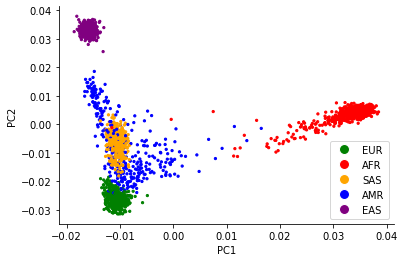

In [32]:
%pylab inline
import pandas as pd
######### Scatterplot #############

# See http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/README_populations.md
def GetSuperpop(pop):
    if pop in ["CHB","JPT","CHS","CDX","KHV"]: return "EAS"
    if pop in ["CEU","TSI","FIN","GBR","IBS"]: return "EUR"
    if pop in ["YRI","LWK","GWD","MSL","ESN","ASW","ACB"]: return "AFR"
    if pop in ["MXL","PUR","CLM","PEL"]: return "AMR"
    if pop in ["GIH","PJL","BEB","STU","ITU"]: return "SAS"
    return "gray"

def LoadData(eigvecfile, sampfile="~/public/lab3/gtdata_sample_labels.csv"):
    """
    Load a pandas data frame with data needed
    to make PCA scatterplots
    
    Arguments
    ---------
    eigvecfile : str
       Path to eigvec file output by plink
    sampfile : str
       Path to sample labels file.
       Format for each line: sample,superpop
       
    Returns
    data : pd.DataFrame
       Pandas dataframe with columns IID, PC1, PC2, etc 
    """
    # Load metadata
    samp = pd.read_csv(sampfile, names=["IID", "pop"])
    samp["superpop"] = samp["pop"].apply(lambda x: GetSuperpop(x), 1)
    
    # Load eigenvecs
    data = pd.read_csv(eigvecfile, 
                   delim_whitespace=True, header=None, usecols=range(7))
    data.columns = ["FID","IID"] + ["PC%s"%i for i in range(1, 6)]

    # Merge sample info
    data = pd.merge(data, samp, on=["IID"], how="left")
    
    # Return merged data
    return data

def PlotPCs(data, pc_x="PC1", pc_y="PC2", highlight_sample=None):
    """
    Create scatter plot of columns $pc_x vs. $pc_y
    
    Arguments
    ---------
    data : pd.DataFrame
       Must have columns $pc_x, $pc_y
    pc_x : str
       Name of the column with the PC to plot
       on the x-axis
    pc_y : str
       Name of the column with the PC to plot
       on the y-axis
    """
    spop_to_color = {
    "EUR": "green",
    "AFR": "red",
    "SAS": "orange",
    "AMR": "blue",
    "EAS": "purple"
    }
    data["color"] = data.apply(lambda x: spop_to_color.get(x["superpop"], "gray"), 1)

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=spop,
                          markerfacecolor=spop_to_color[spop], markersize=10) \
                  for spop in spop_to_color.keys()]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(data[pc_x], data[pc_y], color=data["color"], s=5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y); 
    if highlight_sample is not None:
        assert(highlight_sample in list(data["IID"]))
        sdata = data[data["IID"]==highlight_sample]
        ax.scatter(sdata[pc_x], sdata[pc_y], color="black", s=25)
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=highlight_sample,
                          markerfacecolor="black", markersize=10))
    ax.legend(handles=legend_elements, loc="lower right")


data = LoadData("lab3.eigenvec")
PlotPCs(data, pc_x="PC1", pc_y="PC2")

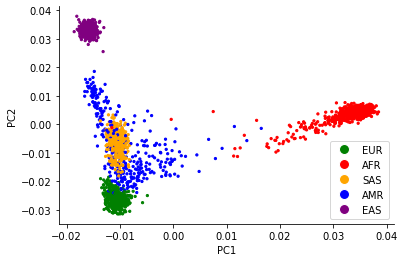

In [36]:
# You can edit the command below to plot additional PCs
PlotPCs(data, pc_x="PC1")

**Question 7 (3 pts)**:

* 7.1 (1 pt): Which superpopulation is separated from the rest along PC1? Set `q7_1` to your answer.
* 7.2 (1 pt): Which superpopulation is separated from EUR and other superpopulations along the PC2? Set `q7_2` to your answer.
* 7.3 (1 pt): Based on where they fall in your PCA plot, which superpopulation do you think has experienced the most recent admixture (contributions of ancestry from many population groups). Set `q7_3` to your answer.

In [37]:
""" Question 7 answers """

# Set to the superpopulation labels that answer 7.1, 7.2, and 7.3 above
# Options: "EUR", "AFR", "EAS", "SAS", "AMR"
q7_1 = ""
q7_2 = ""
q7_3 = ""

# your code here
q7_1 = "AFR"
q7_2 = "EAS"
q7_3 = "AMR"
# raise NotImplementedError

In [38]:
""" Autograder tests - Q7 """
spops = ["EUR","AFR","EAS","SAS","AMR"]
# Check q7_1 makes sense
assert(q7_1 in spops)

# Hidden test checks actual value

In [39]:
""" Autograder tests - Q7 """
spops = ["EUR","AFR","EAS","SAS","AMR"]
# Check q7_2 makes sense
assert(q7_2 in spops)

# Hidden test checks actual value

In [40]:
""" Autograder tests - Q7 """
spops = ["EUR","AFR","EAS","SAS","AMR"]
# Check q7_3 makes sense
assert(q7_3 in spops)

# Hidden test checks actual value

# 5. Determining the ancestry of new samples

Now, we'll use our labeled reference panel to infer the ancestry of a new genome. As a test case, we have included a test genome at `~/public/lab3/friend_genome.vcf.gz`.

The easiest way to determine the ancestry of the new genome is to make a new VCF file including that sample in our PCA analysis. You can use the following shell script we provided to merge the 23andme genome and the reference panel VCF. This script does some cleanup of the 23andme file that is required before merging. If you have done 23andMe, or analyzed your genome through a different company, you're welcome to try this out on your own genome!

```shell
# syntax: preprocess_23andme.sh <23andme VCF> <pruned 1000G VCF> <outdir>
# Note depending on where you run this from, you might have to edit
# the path to preprocess_23andme.sh
# Note the sample ID of the 23andme file will be "GENOTYPE"
# Note you might need to run `chmod +x preprocess_23andme.sh` before running this
./preprocess_23andme.sh \
  ~/public/lab3/friend_genome.vcf.gz \
  ~/lab3/gtdata_1000Genomes_pruned.vcf.gz \
  ~/lab3
```

**Question 8 (10 pts)**: Run the command above to get a new VCF file named `~/lab3/gtdata_merged.vcf.gz`. Then use plink to perform PCA on the new VCF file. Use `--out lab3_merged` so files are named `lab3_merged.eigenvec` etc. Copy the resulting file to the same directory as this notebook. If you did this correctly the tests below should pass.

In [41]:
""" Autograder tests - Q8 """
import os
assert(os.path.isfile("lab3_merged.eigenvec"))
assert(os.stat("lab3_merged.eigenvec").st_size != 0)

In [42]:
""" Autograder tests - Q8 """
import pandas
df = pd.read_csv("lab3_merged.eigenvec", delim_whitespace=True, header=None, usecols=range(7))
df.columns = ["FID","IID"] + ["PC%s"%i for i in range(1, 6)]
assert("HG00103" in list(df["IID"]))
assert("GENOTYPE" in list(df["IID"]))

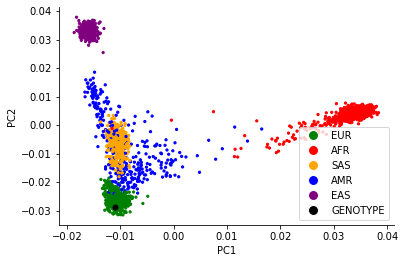

In [43]:
""" Autograder tests - Q8 """
# This should successfully output a scatterplot if your PCA
# worked
data = LoadData("lab3_merged.eigenvec")
PlotPCs(data, pc_x="PC1", pc_y="PC2", highlight_sample="GENOTYPE")

**Question 9 (2 pts)**: What do you predict is the superpopulation label of the unknown sample? Set `q9_pop` to your answer below.

In [44]:
""" Question 9 answers """
q9_pop = "" # set to 1 of "EUR", "AFR", "AMR", "SAS", "EAS"

# your code here
q9_pop = "EUR"
# raise NotImplementedError

In [45]:
""" Autograder tests - Q9 """
spops = ["EUR","AFR","EAS","SAS","AMR"]
assert(q9_pop in spops)

# Hidden test checks actual value